# Advanced Lane Detection


In [1]:
### Camera Calibration via images

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

images_path=glob.glob('D:\SankarStuff\SDC_ND\CarND-Advanced-Lane-Lines\camera_cal\Calibration*.jpg')

nx=9
ny=6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for img_path in images_path:
    
    fname = img_path
    img = cv2.imread(fname)
    
    # prepare object points
    
    nx = 9#TODO: enter the number of inside corners in x
    ny = 6#TODO: enter the number of inside corners in y

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:        
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners        
        #out=cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #cv2.imshow('img',out)
        #cv2.waitKey(5000)        
        
#cv2.destroyAllWindows()

## Calibrate the camera using all imgpoints and objpoints obtained above

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)


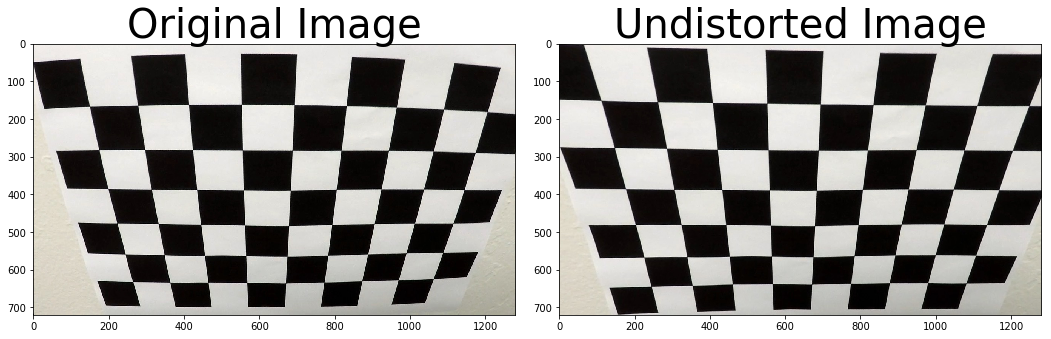

In [2]:
# Undistort images 

img_test = mpimg.imread('D:\SankarStuff\SDC_ND\CarND-Advanced-Lane-Lines\camera_cal\Calibration2.jpg')

undist = cv2.undistort(img_test, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


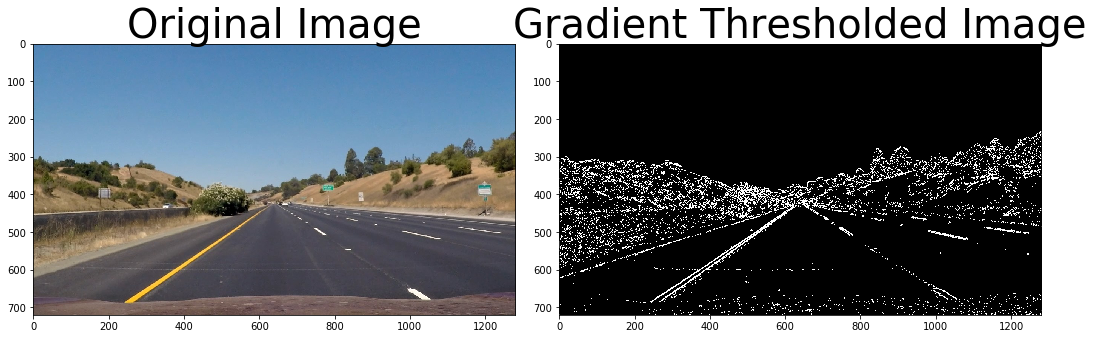

In [4]:
## Lane detection - step 1 - thresholding with sobel operators

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

img=mpimg.imread('D:/SankarStuff/SDC_ND/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, 'x',10,200)
grady = abs_sobel_thresh(img, 'y',5,200)
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(400,1000))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(np.pi/6, np.pi/2))

gradient_binary = np.zeros_like(dir_binary)
gradient_binary[(gradx == 1) & (dir_binary == 1)] = 1 ## magnitude/sobely did not add much value

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(gradient_binary,cmap='gray') ## note the cmap argument for displaying grayscale image matplotlib
ax2.set_title('Gradient Thresholded Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

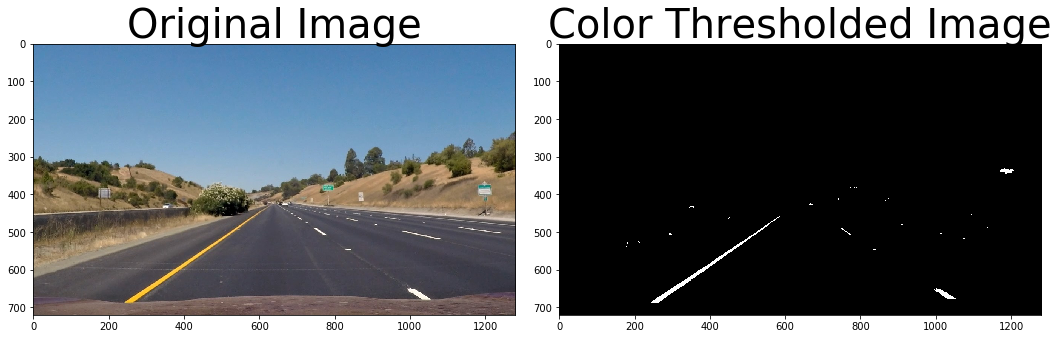

In [5]:
## Lane detection - step 2 - thresholding with color spaces (HLS - Hue, Lightness and Saturation)

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hls_select_l(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def rgb_threshold(img,thresh):
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > thresh) & (G > thresh)
    return r_g_condition  

img=mpimg.imread('D:/SankarStuff/SDC_ND/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')

s_binary = hls_select(img, thresh=(120, 255)) ## operating on the s-channel which works best for white/yellow lines
l_binary=hls_select_l(img,thresh=(120,255)) ## needed when operating on shadows
r_g_binary=rgb_threshold(img,150)

hls_binary = np.zeros_like(s_binary)

hls_binary[(s_binary == 1) & (l_binary == 1)]=1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(hls_binary,cmap='gray') ## note the cmap argument for displaying grayscale image matplotlib
ax2.set_title('Color Thresholded Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

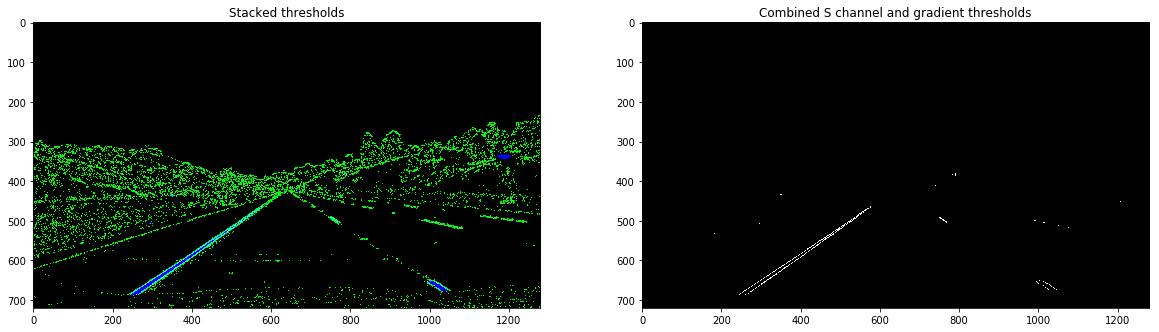

In [6]:
### Combine gradient (sobelx) and color (s-channel thresholds)

color_binary = np.dstack(( np.zeros_like(gradient_binary), gradient_binary, hls_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(gradient_binary)
combined_binary[(gradient_binary == 1) & (hls_binary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds') # green is the gradient threshold component and blue is color threshold component
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.show()

In [ ]:
### Apply masking using region of interest

#mask = np.zeros_like(combined_binary)
mask = np.zeros_like(hls_binary)
height=img.shape[0]
width=img.shape[1]
region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
cv2.fillPoly(mask, [region_of_interest_vertices], 1)
#thresholded = cv2.bitwise_and(combined_binary, mask)
thresholded = cv2.bitwise_and(hls_binary, mask)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Color and gradient threshold') # green is the gradient threshold component and blue is color threshold component
ax1.imshow(hls_binary,cmap='gray')

ax2.set_title('Masked')
ax2.imshow(thresholded, cmap='gray')
plt.show()

In [ ]:
### Perspective transform

%matplotlib inline

def warp(img,src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size=(img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

src=np.float32([[722,470],#top right
    [1110,720], #bottom right
    [220,720], #bottom left
    [570,470]])
dst=np.float32([[920,1],#top right
    [920,720], #bottom right
    [320,720], #bottom left
    [320,1]]) #top left

warped=warp(thresholded,src,dst)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Thresholded Image')
ax1.imshow(thresholded,cmap='gray')

ax2.set_title('Perspective Transformed')
ax2.imshow(warped,cmap='gray')
plt.show()

In [ ]:
### Lane finding: peaks in a histogram

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [ ]:
### Sliding window implementation based on histogram peaks

binary_warped=warped

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    print(win_xleft_low,win_xleft_high,win_xright_low,win_xright_high)
    
    # Draw the windows on the visualization image- some problem... window not displaying on image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(left_fit,right_fit)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [ ]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
### Fill detected lanes and transfer back to original image

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

M_inv = cv2.getPerspectiveTransform(dst,src)
img_size=(img.shape[1],img.shape[0])

unwarped = cv2.warpPerspective(color_warp, M_inv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

plt.imshow(result)

In [ ]:
### Display radius of curvature and offset from center of lane on image

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

average_curve_rad = (left_curverad + right_curverad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad

# compute the offset from the center
lane_center = (left_fitx[binary_warped.shape[0]-1] + right_fitx[binary_warped.shape[0]-1])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs

cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(result,offset_string , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
plt.imshow(result)

In [ ]:
##### SUMMARIZE ALL FUNCTIONS NEEDED TO BUILD FINAL PIPELINE #########

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hls_select_l(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def rgb_threshold(img,thresh):
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > thresh) & (G > thresh)
    return r_g_condition 

def warp(img,src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size=(img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def sliding_windows_lane(warped):

    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global left_lane_history
    global right_lane_history
    global lane_width_curr
    global lane_width_movingavg
    
    print('sliding windows')
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    
    binary_warped=warped

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
        
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image- some problem... window not displaying on image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #####----- HISTORY ------##############
    #left_lane_history=[]
    #right_lane_history=[]
    
    #left_lane_history.append(left_fitx)
    #right_lane_history.append(right_fitx)
    
    #lane_width_curr= np.mean(right_fitx - left_fitx)
    #lane_width_movingavg=lane_width_curr   
    
    ###------------------------############

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
       
    return out_img
    
def lane_detect(binary_warped):
    
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global left_lane_history
    global right_lane_history
    global lane_width_curr
    global lane_width_movingavg
    global debug
    global debug_lw_curr
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (len(leftx)==0 or len(lefty)==0 or len(rightx)==0 or len(righty)==0 ):
        result=binary_warped
    else:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx_new = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx_new = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        lane_width_curr=np.mean(right_fitx_new-left_fitx_new)
        
        if lane_width_movingavg==0:
            lane_width_movingavg=lane_width_curr
                        
        tol=0.25
        if (lane_width_curr>(1+tol)*lane_width_movingavg) or (lane_width_curr<(1-tol)*lane_width_movingavg):
            badlines=True
        else:
            badlines=False
            lane_width_movingavg=0.8*lane_width_curr+0.2*lane_width_movingavg
            debug.append(lane_width_movingavg)
            debug_lw_curr.append(lane_width_curr)
             
                
        ##### ------ AVERAGING SCHEME ----------####################

        if badlines==False:
            left_lane_history.append(left_fitx_new)
            right_lane_history.append(right_fitx_new)            
        else:            
            #left_fitx=left_lane_history[-1]
            #right_fitx=right_lane_history[-1]            
            new=sliding_windows_lane(binary_warped)   
            #badlines=False
        
        left_fitx=calc_avg_line(left_lane_history,left_fitx_new,15)
        right_fitx=calc_avg_line(right_lane_history,right_fitx_new,15)
        
        ###### --------------------------------#####################



        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
   
    return result

def calc_avg_line(line_history,new_line,n):
    
    hist_np=np.asarray(line_history)
    
    if len(line_history)<n:
        fitx=hist_np[-1]
    else:          
        new_line = np.zeros_like(new_line)
        for i in range(n):
            new_line += line_history[i]
        fitx=new_line/n
    return fitx
    

def drawPolygon(img,warped,src,dst):
    
    global img_size
    global left_fitx
    global right_fitx
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    M_inv = cv2.getPerspectiveTransform(dst,src)    

    unwarped = cv2.warpPerspective(color_warp, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    return result

def curvature_offset(binary_warped,result):
    
    global left_fitx
    global right_fitx
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    ### Display radius of curvature and offset from center of lane on image
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    average_curve_rad = (left_curverad + right_curverad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad

    # compute the offset from the center
    lane_center = (left_fitx[binary_warped.shape[0]-1] + right_fitx[binary_warped.shape[0]-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs

    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result,offset_string , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result





In [ ]:
### Creating a final pipeline for each image

def final_pipeline(img):
    
    global left_fit
    global right_fit
    global img_size
    global left_fitx
    global right_fitx    
    global left_lane_history
    global right_lane_history
    global lane_width_movingavg
    global lane_width_curr
    
    # -----------Step1: Undistort an incoming image-----------#
    
    undist = cv2.undistort(img, mtx, dist, None, mtx) 
    
    # -----------Step2: Apply gradient threshold ------------#
    
    ksize = 3 
    gradx = abs_sobel_thresh(img, 'x',5,200)
    grady = abs_sobel_thresh(img, 'y',5,100)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(np.pi/6, np.pi/2))
    gradient_binary = np.zeros_like(dir_binary)
    gradient_binary[(gradx == 1) & (dir_binary == 1)] = 1
    
    # -----------Step3: Apply color threshold ------------#
    
    s_binary = hls_select(img, thresh=(100, 255)) ## operating on the s-channel which works best for white/yellow lines
    l_binary=hls_select_l(img,thresh=(120,255))
    r_g_binary=rgb_threshold(img,150)

    hls_binary = np.zeros_like(s_binary)

    hls_binary[(s_binary == 1) & (l_binary == 1)&(r_g_binary==1)]=1
    
    
    # -----------Step4a: Combine gradient and color thresholds ------------#
    
    color_binary = np.dstack(( np.zeros_like(gradient_binary), gradient_binary, hls_binary))    
    combined_binary = np.zeros_like(gradient_binary)
    combined_binary[(gradient_binary == 1) & (hls_binary == 1)] = 1
    
    # -----------Step4b: Mask based on region of interest ------------#
    
    #mask = np.zeros_like(combined_binary) # changed from combined to just color thresholding
    x_min = 0
    y_min = 0
    x_max = img.shape[1]
    y_max = img.shape[0]

    top_right = [x_max*0.585, y_max*0.64]
    bottom_right = [x_max-0, y_max]
    bottom_left = [x_min+55, y_max]
    top_left = [x_max*0.425, y_max*0.64]
    vertices = np.array([[top_left, top_right, bottom_right, bottom_left]], dtype=np.int32)
    
    mask = np.zeros_like(hls_binary) # changed from combined to just color thresholding
    #height=img.shape[0]
    #width=img.shape[1]
    #region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [vertices], 1)
    #thresholded = cv2.bitwise_and(combined_binary, mask)
    thresholded = cv2.bitwise_and(hls_binary, mask)
    
    # -----------Step5: Apply a perspective transform on image ------------#
    
    src=np.float32([[722,470],#top right
        [1110,720], #bottom right
        [220,720], #bottom left
        [570,470]])
    dst=np.float32([[920,1],#top right
        [920,720], #bottom right
        [320,720], #bottom left
        [320,1]]) #top left

    warped=warp(thresholded,src,dst)  
    
    # -----------Step6: Histogram peak to detect lanes ------------#
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    histogram[0:100]=0
    histogram[1175:]=0
        
    # -----------Step7: Sliding window implementation based on histogram peaks------------#
    #------------This step will happen only if lanes are detected for first time or ------#
    #------------if the algorithm suddenly loses track of lanes---------------------------#
    
    if (left_fit is None) or (right_fit is None):
        out_img=sliding_windows_lane(warped)
        print('executing sliding windows')
    else:    
    # ------Step 8: Continuous lane detection..Fitting a polynomial for left & right lanes--#
        out_img=lane_detect(warped)
        
    # ------Step 9: Draw polygon between the detected left and right lanes on the road------#
    
    poly_img=drawPolygon(img,warped,src,dst)
    
    # ---- Step 10: Calculate radius of curvature and offset from center of road & display--#
    
    final_img=curvature_offset(warped,poly_img)
           
    return poly_img


In [ ]:
## Test final pipeline

%matplotlib inline
import collections

img_sample=mpimg.imread('D:/SankarStuff/SDC_ND/CarND-Advanced-Lane-Lines/test_images/test4.jpg')

left_fit=None
right_fit=None
left_fitx=None
right_fitx=None
img_size=(img.shape[1],img.shape[0])
left_lane_history=collections.deque(maxlen=5)
right_lane_history=collections.deque(maxlen=5)
lane_width_movingavg=0
lane_width_curr=0

out=final_pipeline(img_sample)
print(lane_width_movingavg)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Raw Image') # green is the gradient threshold component and blue is color threshold component
ax1.imshow(img_sample)

ax2.set_title('Processed')
ax2.imshow(out, cmap='gray')
plt.show()

In [ ]:
img_sample=mpimg.imread('D:/SankarStuff/SDC_ND/CarND-Advanced-Lane-Lines/test_images/test5.jpg')
out=final_pipeline(img_sample)
print(lane_width_movingavg)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Raw Image') # green is the gradient threshold component and blue is color threshold component
ax1.imshow(img_sample)

ax2.set_title('Processed')
ax2.imshow(out, cmap='gray')
plt.show()

In [ ]:
### Video

from moviepy.editor import VideoFileClip
import collections

left_fit=None
right_fit=None
left_fitx=None
right_fitx=None
img_size=(img.shape[1],img.shape[0])
left_lane_history=collections.deque(maxlen=15)
right_lane_history=collections.deque(maxlen=15)
lane_width_movingavg=0
lane_width_curr=0
debug=[]
debug_lw_curr=[]


output = 'project_video_full_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(35,45)
white_clip = clip1.fl_image(final_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)


In [ ]:
print(debug)
print()
print(debug_lw_curr)




In [ ]:
https://youtu.be/d5KURcDlJ-s